## Загрузка данных и библиотек

In [3]:
import pandas as pd 
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import PowerTransformer
from sklearn.utils.class_weight import compute_class_weight
from catboost import CatBoostClassifier


In [4]:
df = pd.read_csv('data/train.csv')
df.sample(10)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
2312,29,34.30,1004.75,Male,0,No,No,No,No phone service,DSL,No,Yes,No,Yes,No,No,Month-to-month,No,Electronic check,0
3693,58,65.25,3791.6,Female,0,Yes,No,Yes,No,DSL,Yes,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),0
1195,68,110.25,7279.35,Female,0,No,No,Yes,Yes,Fiber optic,Yes,Yes,No,Yes,Yes,Yes,Two year,No,Credit card (automatic),0
3432,27,86.45,2401.05,Female,1,No,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,No,No,Month-to-month,Yes,Bank transfer (automatic),0
48,39,19.90,791.15,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1609,32,74.75,2282.95,Female,0,No,No,Yes,Yes,DSL,Yes,No,No,No,Yes,Yes,One year,No,Mailed check,0
686,7,48.80,349.8,Female,0,Yes,Yes,Yes,Yes,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,0
4311,56,98.00,5270.6,Female,0,Yes,No,Yes,Yes,Fiber optic,Yes,No,No,No,Yes,Yes,One year,Yes,Electronic check,0
5126,52,100.30,5244.45,Female,0,Yes,Yes,Yes,No,Fiber optic,Yes,No,Yes,No,Yes,Yes,One year,No,Electronic check,0
2304,3,75.25,242,Female,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,No,Electronic check,1


## Анализ данных

Пункт 1.2 Посомтрим на пропуски в наших данных и на их типы:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

В наших данных нет пропусков.
Признаки **ClientPeriod**, **MonthlySpending**, **TotalSpent** являются числовыми, все остальные категориальные.

Изучим более подробно каждый признак, начнём с целевой переменной (пункт 2.2)

In [ ]:
display(df['Churn'].value_counts())
target = df['Churn'].value_counts(normalize=True).to_list() #считаем доли 

print(f'Пользователей осталось: {target[0] * 100:.2f}%, ушло: {target[1] * 100:.2f}%')

Churn
0    3898
1    1384
Name: count, dtype: int64

Пользователей осталось: 73.80%, ушло: 26.20%


Как можно заметить у нас присуствует небольшой дизбаланс классов.

Теперь иследуем числовые фичи. (пункт 2.1)

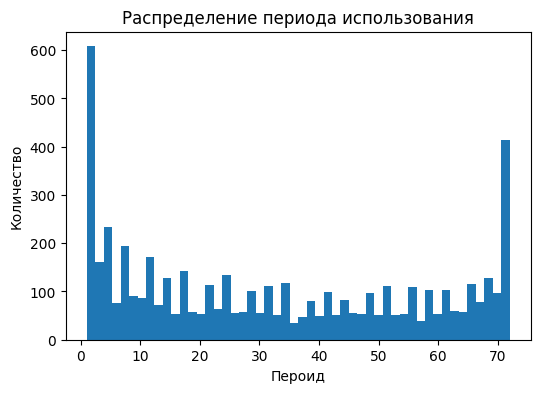

In [89]:
plt.figure(figsize=[6,4])
plt.hist(df['ClientPeriod'], bins=50)
plt.title('Распределение периода использования')
plt.xlabel('Пероид')
plt.ylabel('Количество')
plt.show()

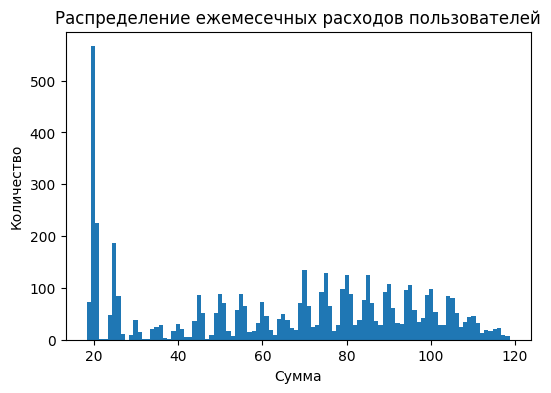

In [92]:
plt.figure(figsize=[6,4])
plt.hist(df['MonthlySpending'],bins=100)
plt.title('Распределение ежемесечных расходов пользователей')
plt.xlabel('Сумма')
plt.ylabel('Количество')
plt.show()

Признак TotalSpent у нас является object, хотя по факту это числовой признак, исправим это.

In [6]:
df['TotalSpent'] = pd.to_numeric(df['TotalSpent'], errors='coerce')
print(f"Количество NaN: {df['TotalSpent'].isna().sum()}") #так как errors='coerce' присваивает всем неконркетным значениям NaN сразу узнаем их количество

Количество NaN: 9


Теперь у нас есть 9 проусков, так как их мало, то просто удалим эти строки.

In [7]:
df = df.dropna(subset=['TotalSpent'])

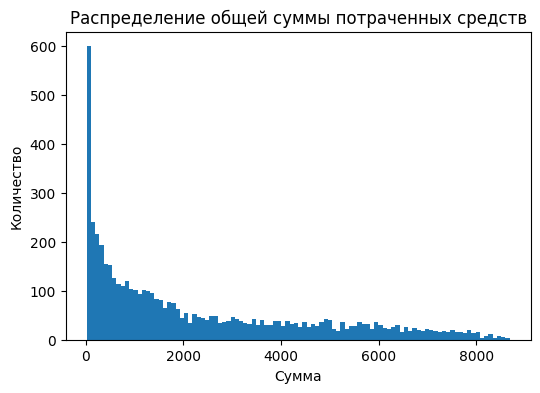

In [93]:
plt.figure(figsize=[6,4])
plt.hist(df['TotalSpent'], bins=100)
plt.title('Распределение общей суммы потраченных средств')
plt.xlabel('Сумма')
plt.ylabel('Количество')
plt.show()


Судя по гистограме большое количество пользователей ничего не потратило, попробуем исправить это, но только для линейной регрессии, так как дерьвья справляются с такими распределением.

А так же посмотрим, есть ли у нас выбросы(их нет):

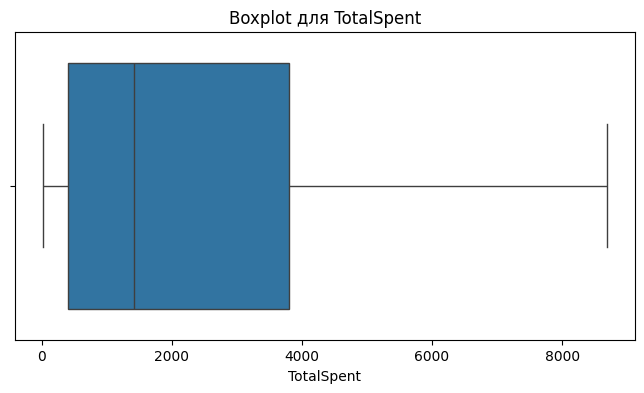

In [45]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['TotalSpent'])
plt.title('Boxplot для TotalSpent')
plt.show()

Теперь изучим, категориальные переменные.

Посмотрим, какие из них бинарные, а какие нет:

In [10]:
# Категориальные признаки
cat_cols_full = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]
for name in cat_cols_full:
    print(f'Название фичи {name}, количесвто уникальных значений: {df[name].nunique()}' )

Название фичи Sex, количесвто уникальных значений: 2
Название фичи IsSeniorCitizen, количесвто уникальных значений: 2
Название фичи HasPartner, количесвто уникальных значений: 2
Название фичи HasChild, количесвто уникальных значений: 2
Название фичи HasPhoneService, количесвто уникальных значений: 2
Название фичи HasMultiplePhoneNumbers, количесвто уникальных значений: 3
Название фичи HasInternetService, количесвто уникальных значений: 3
Название фичи HasOnlineSecurityService, количесвто уникальных значений: 3
Название фичи HasOnlineBackup, количесвто уникальных значений: 3
Название фичи HasDeviceProtection, количесвто уникальных значений: 3
Название фичи HasTechSupportAccess, количесвто уникальных значений: 3
Название фичи HasOnlineTV, количесвто уникальных значений: 3
Название фичи HasMovieSubscription, количесвто уникальных значений: 3
Название фичи HasContractPhone, количесвто уникальных значений: 3
Название фичи IsBillingPaperless, количесвто уникальных значений: 2
Название фичи P

In [ ]:
N = len(cat_cols_full)

plt.figure(figsize=(N, 5*N))
for i, col in enumerate(cat_cols_full):
  col = cat_cols_full[i // 2]
  vc = df[col].value_counts()
  labels = vc.index.to_list()
  values = vc.values
  plt.subplot(N, 2, i + 1)
  if i % 2 == 0:
    plt.pie(values, labels=labels)
    plt.title(f"Pie_{col}")
  elif i % 2 == 1:
    plt.bar(labels, values)
    plt.title(f"Bar_{col}")
plt.show()

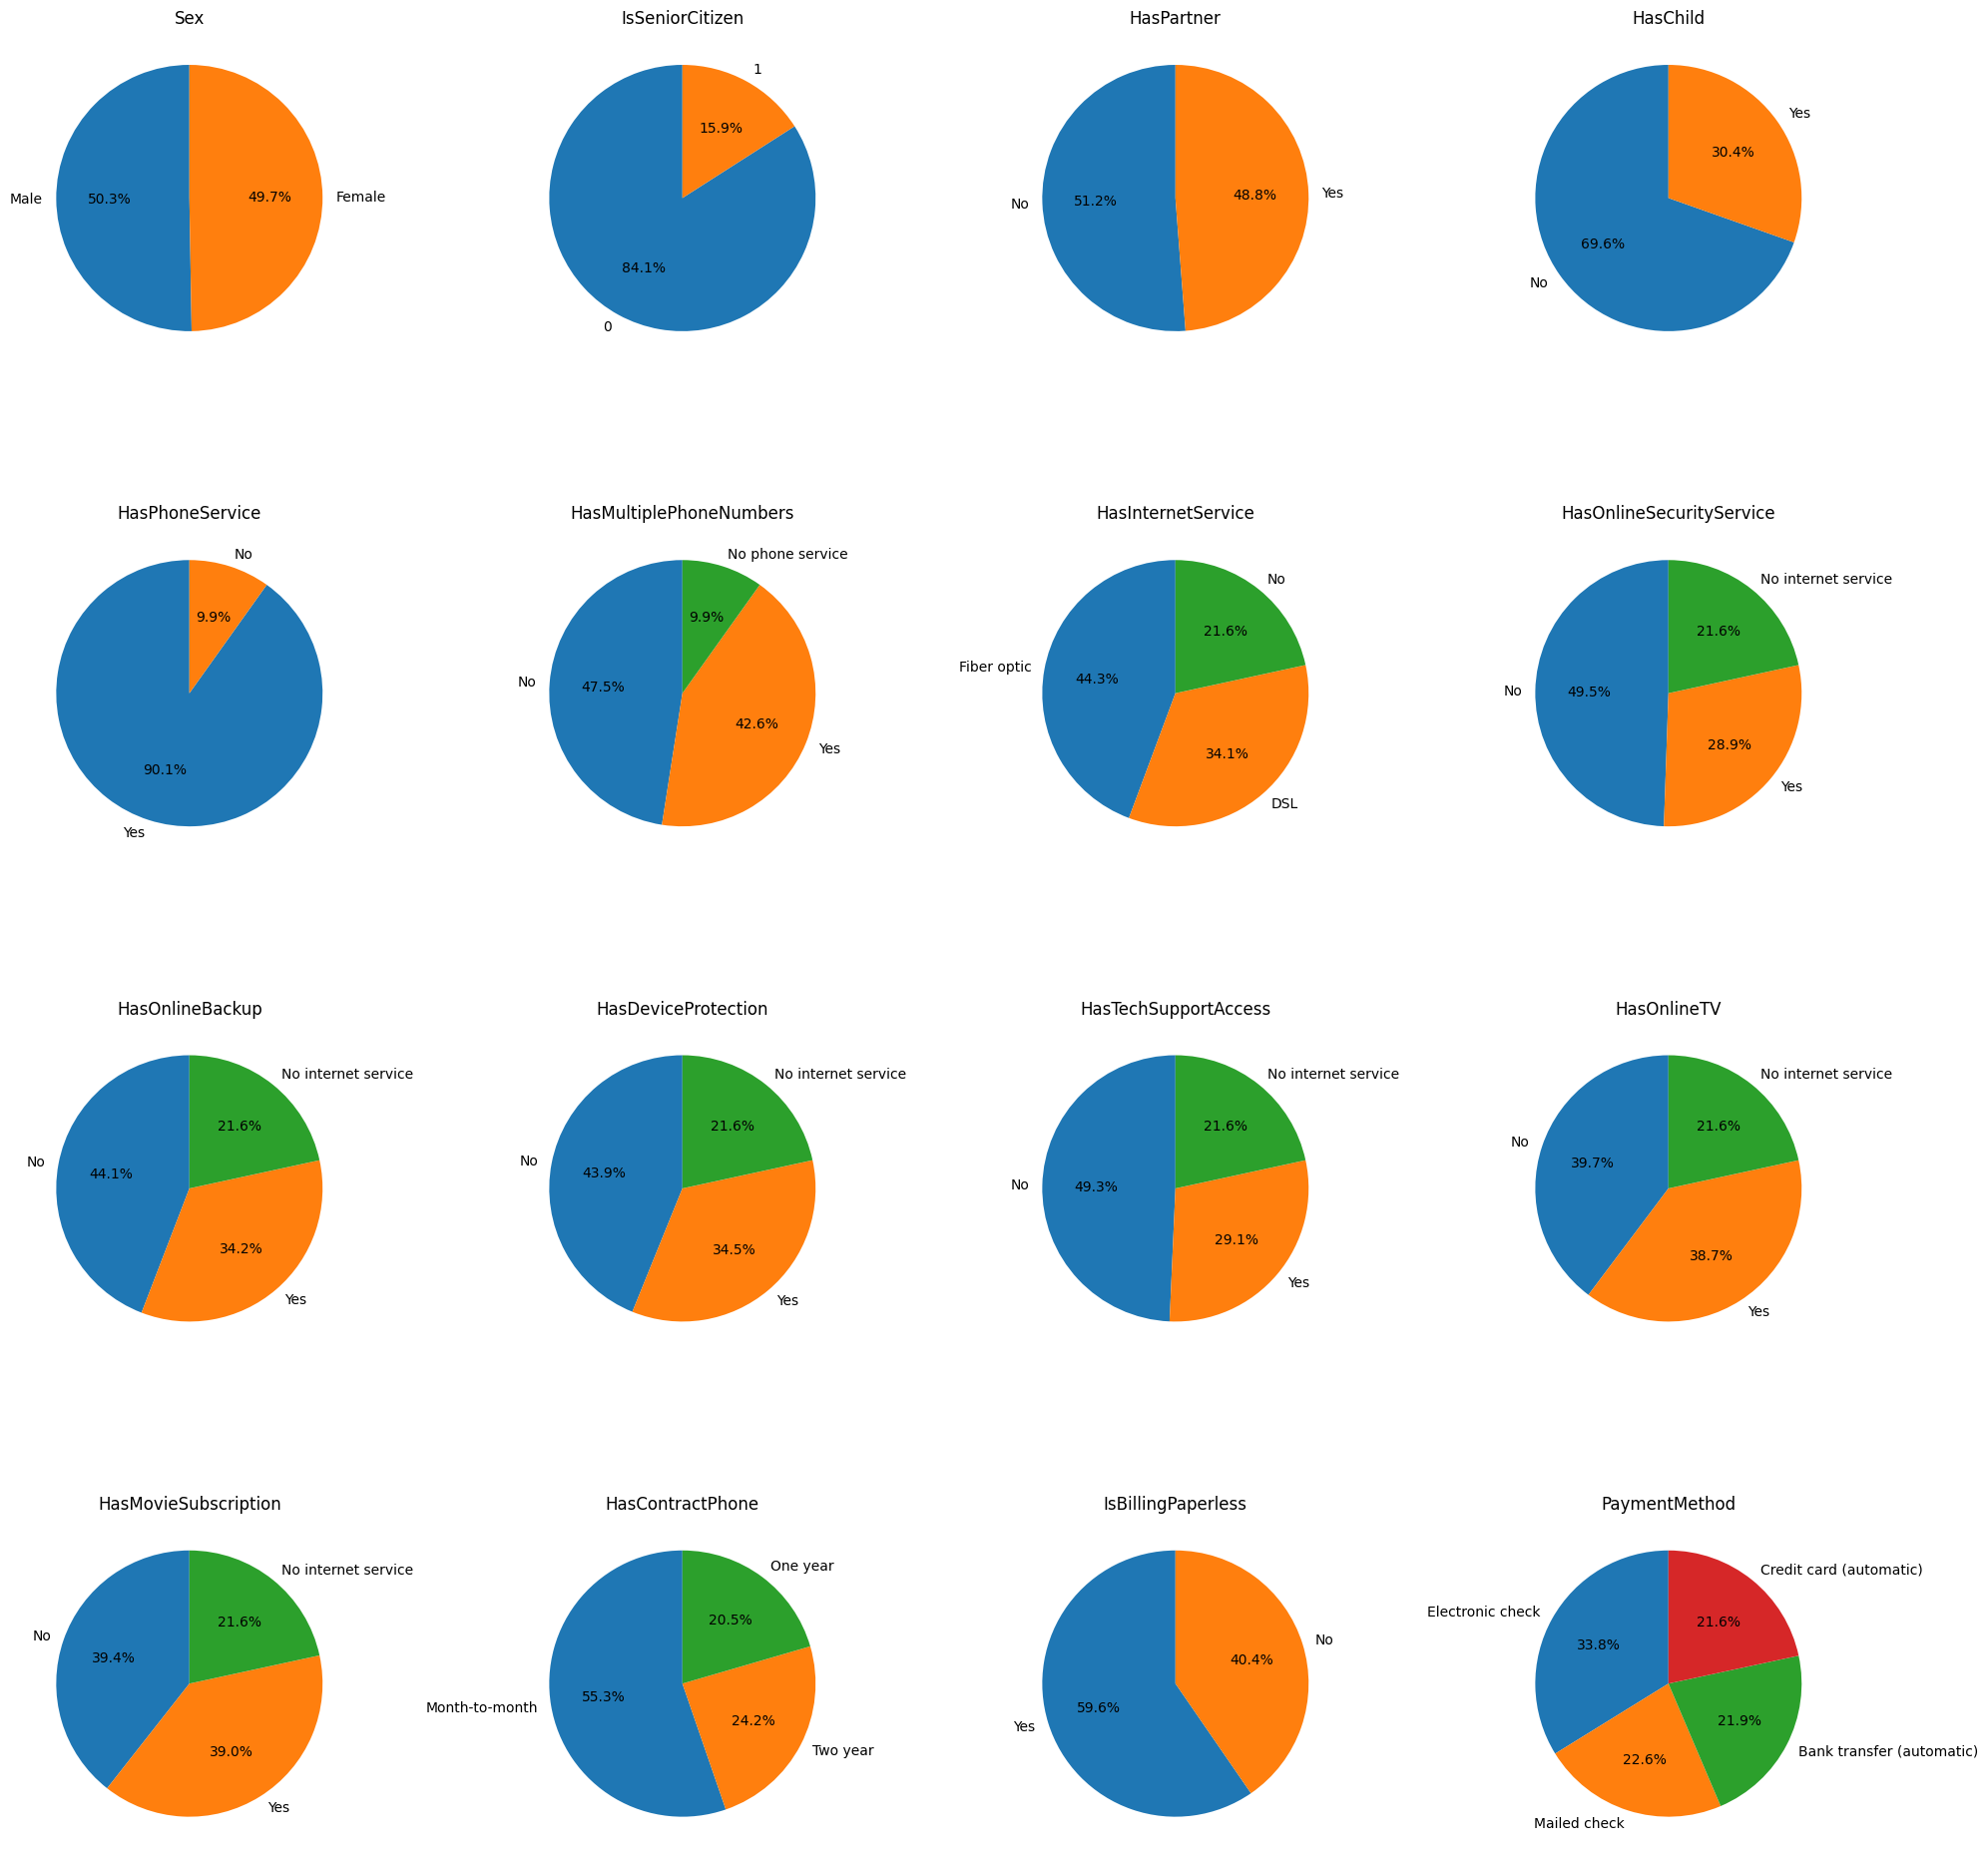

In [ ]:
n_cols = 4 
n_rows = 4  

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 5 * n_rows))

# делаем axes одномерным списком 
axes = axes.flatten()

for ax, col in zip(axes, cat_cols_full):
    values = df[col].value_counts()
    ax.pie(values, labels=values.index, autopct='%1.1f%%', startangle=90)
    ax.set_title(col)

# если подграфиков больше, чем признаков — выключаем лишние
for ax in axes[len(cat_cols_full):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
for col in cat_cols_full:
    print(f'\n--- {col} ---')
    print(df.groupby(col)['Churn'].agg(['mean', 'count']))


--- Sex ---
            mean  count
Sex                    
Female  0.266209   2622
Male    0.258770   2651

--- IsSeniorCitizen ---
                     mean  count
IsSeniorCitizen                 
0                0.232453   4431
1                0.420428    842

--- HasPartner ---
                mean  count
HasPartner                 
No          0.325814   2704
Yes         0.195796   2569

--- HasChild ---
              mean  count
HasChild                 
No        0.309576   3676
Yes       0.154039   1597

--- HasPhoneService ---
                     mean  count
HasPhoneService                 
No               0.248555    519
Yes              0.263988   4754

--- HasMultiplePhoneNumbers ---
                             mean  count
HasMultiplePhoneNumbers                 
No                       0.247209   2508
No phone service         0.248555    519
Yes                      0.282725   2246

--- HasInternetService ---
                        mean  count
HasInternetService   

Можно увидеть, что у признаков **Sex**, **HasPhoneService**, **HasMultiplePhoneNumbers** практически одинаковые доли, значит сами по себе эти признаки не принесут нашей модели пользы в предсказаниях(справедливо только для линейных моделей, так как бустинги могут улавливать более сложные зависимости)

Пункт 2.3 попробуем воспользоваться другими для визуализации, попробуем  **ydata-profiling**

In [ ]:
report = ProfileReport(df, title="EDA Report", explorative=True)
report.to_notebook_iframe() # для отоброжения нужна библиотека ipywidgets (pip install ipywidgets)


Render HTML: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


Очень мощная библиотека и отличный иструмент для анализа данных, который не только показывает много различных статистик, но так же и указывает на проблемы в наших данных(Alerts)

## По результатам EDA имеем:
* 14 дубликатов
* При переводе **TotalSpent** из Object в Float, получили 9 NaN(которые уже были удалены)
* В распределение числовых признаков есть перекосы, исправим это при подготовке данных для лин. регрессии
* Признак в **HasPhoneService** только 10% пользователей не имеют мобильного приложения
* Признаки **Sex**, **HasPhoneService**, **HasMultiplePhoneNumbers** малоинформативны, что подвержает, как сравнение долей, так и матрица корреляции
* Так же признаки **HasPhoneService** и  **HasMultiplePhoneNumbers** сильно скорелированны

In [113]:
print(df.duplicated().sum())
df.drop_duplicates(inplace= True) #удалим дубликаты
print(df.duplicated().sum())

14
0


## Линейные модели

### Подготовка обучающего датасета

In [37]:
#Копируем наш датасет, чтобы оставить оригинальный df для бустинга 
df_ln = df.copy()

Для начала подправим распределения в наших числовых данных

В ходе экспериментов для признака **TotalSpent** эффективнее всего метод 'yeo-johnson' из библиотеки PowerTransformer, а для **ClientPeriod**, **MonthlySpending** не получилось снизить асиметрию, ну она вроде бы не сильно высокая( 0.23 и -0.22)

Асимметрия до: 0.9518649114076824
Асимметрия после: -0.1449735575529764


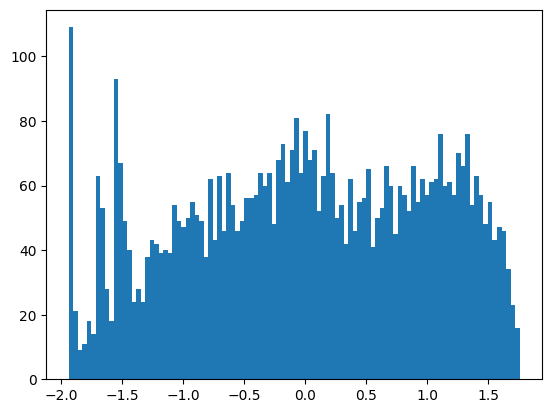

In [38]:
pt = PowerTransformer(method='yeo-johnson')

print(f'Асимметрия до: {df_ln["TotalSpent"].skew() }') # skew() - показывает степень асимметрии распределения данных
df_ln['TotalSpent'] = pt.fit_transform(df_ln[['TotalSpent']])
print(f'Асимметрия после: {df_ln["TotalSpent"].skew()}')

plt.hist(df_ln['TotalSpent'], bins=100)
plt.show()

Удалим признаки Sex, HasPhoneService, HasMultiplePhoneNumbers, так они не информативные для линейной регрессии

Теперь ещё раз посмотрим на матрицу корреляции: 


In [39]:
df_ln.drop(columns=['Sex', 'HasPhoneService', 'HasMultiplePhoneNumbers'],inplace=True)
co_matrix = df_ln.corr(numeric_only= True)

<Axes: >

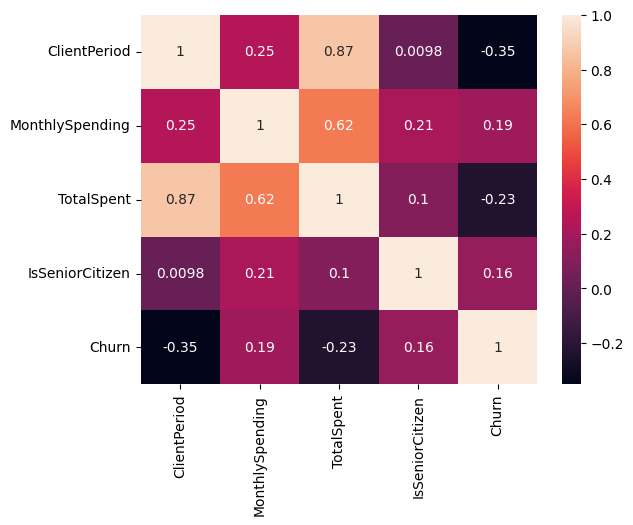

In [40]:
sns.heatmap(co_matrix,annot=True)

In [42]:
cat_cols = [
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
] #учитывая удалёные три фичи

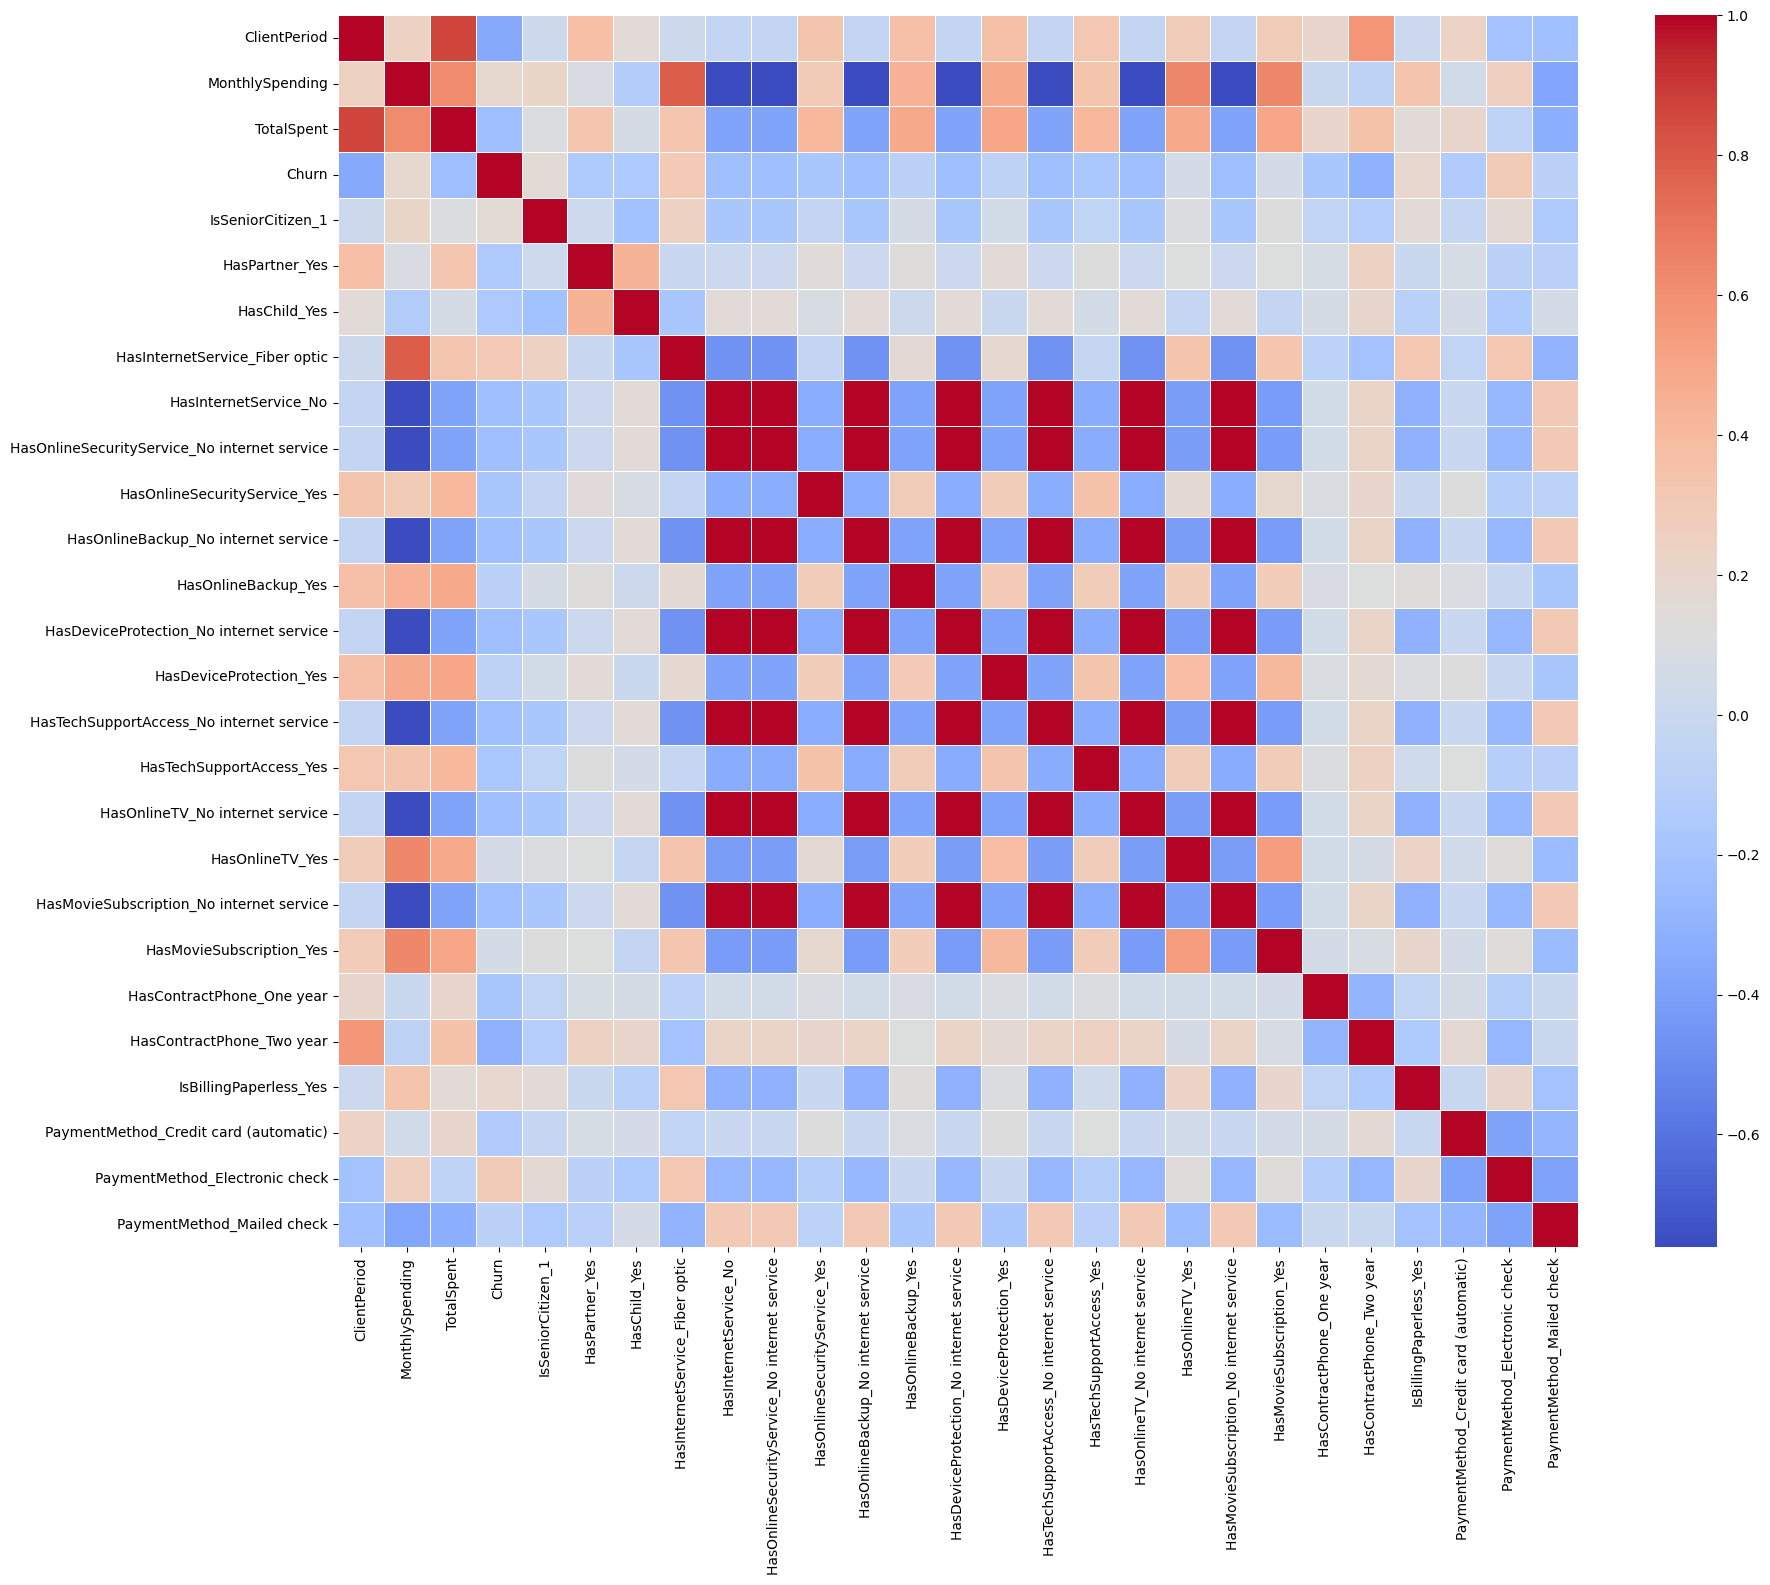

In [ ]:
df_encoded = pd.get_dummies(df_ln, columns=cat_cols, drop_first=True)
corr = df_encoded.corr()
plt.figure(figsize=(20, 16)) 
sns.heatmap(corr, annot=False, linewidths=0.5 , cmap="coolwarm")
plt.show()

Можно увидеть, что многие фичи сильно коррелируют между собой, а у **MonthlySpending** отрицательная корреляция с **HasInternetService** и аналогичными, что логично, ведь если услуга не подключена, то в месяц расходы меньше. 

In [44]:
df_encoded.columns

Index(['ClientPeriod', 'MonthlySpending', 'TotalSpent', 'Churn',
       'IsSeniorCitizen_1', 'HasPartner_Yes', 'HasChild_Yes',
       'HasInternetService_Fiber optic', 'HasInternetService_No',
       'HasOnlineSecurityService_No internet service',
       'HasOnlineSecurityService_Yes', 'HasOnlineBackup_No internet service',
       'HasOnlineBackup_Yes', 'HasDeviceProtection_No internet service',
       'HasDeviceProtection_Yes', 'HasTechSupportAccess_No internet service',
       'HasTechSupportAccess_Yes', 'HasOnlineTV_No internet service',
       'HasOnlineTV_Yes', 'HasMovieSubscription_No internet service',
       'HasMovieSubscription_Yes', 'HasContractPhone_One year',
       'HasContractPhone_Two year', 'IsBillingPaperless_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [ ]:
#удалим сильно скорелированые признаки
df_clear = df_encoded.drop(columns=['TotalSpent',
                                    'HasInternetService_No',
                                    'HasOnlineBackup_No internet service',
                                    'HasDeviceProtection_No internet service',
                                    'HasTechSupportAccess_No internet service',
                                    'HasOnlineTV_No internet service',
                                   'HasMovieSubscription_No internet service'])

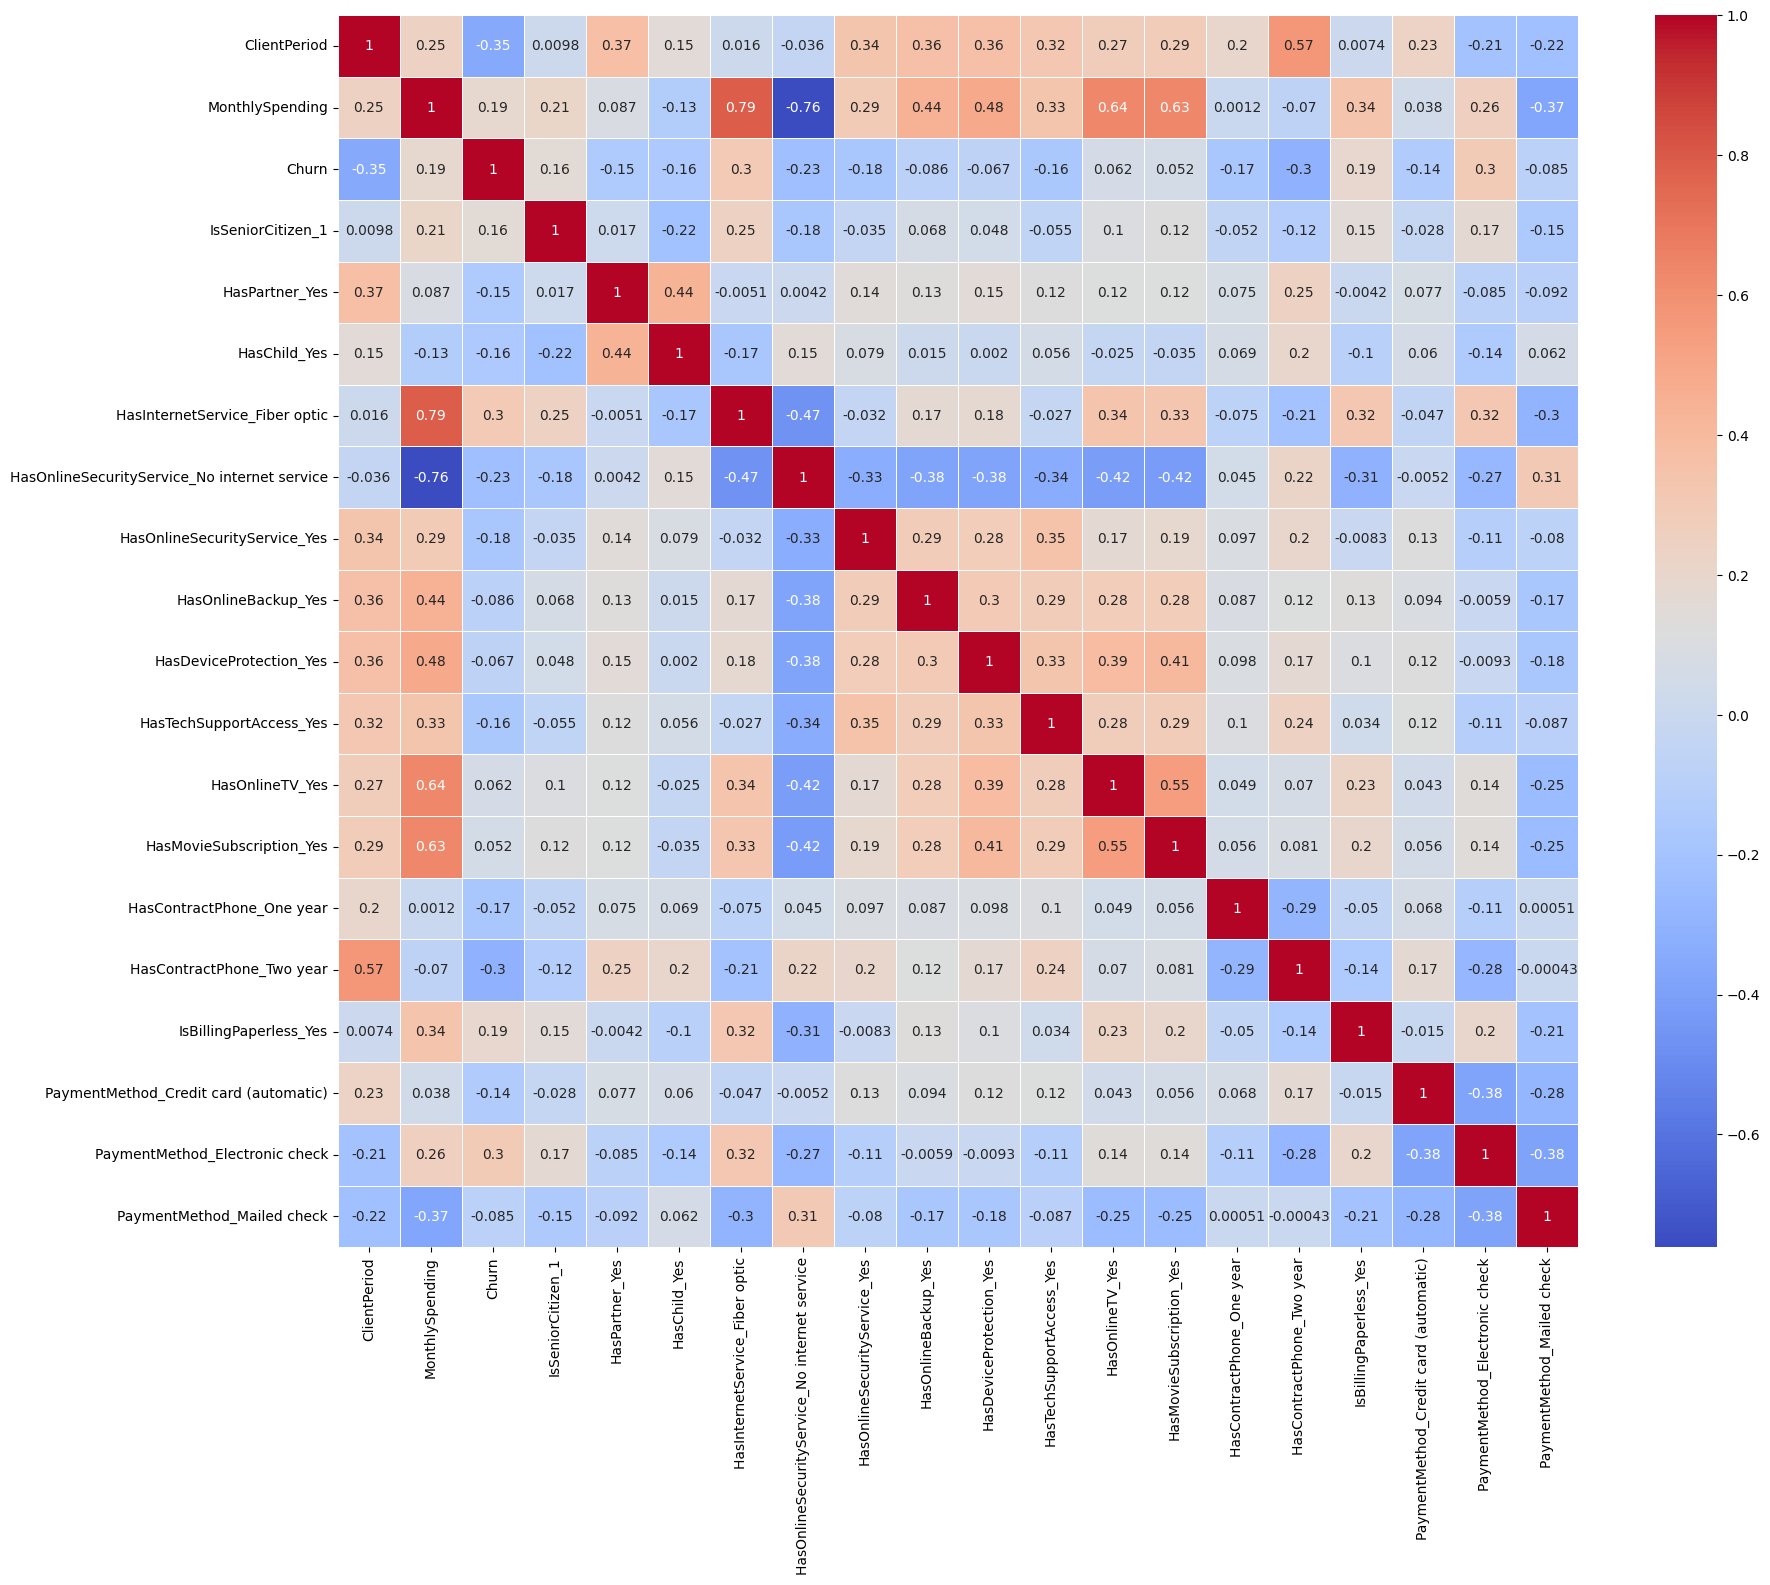

In [46]:
cor = df_clear.corr()
plt.figure(figsize=(20, 16)) 
sns.heatmap(cor,annot= True, linewidths=0.5 , cmap="coolwarm")
plt.show()

Намного лучше, но всё таки ещё присутствуют скоррелированные признаки, но оставим так, у нас нет цели выбить лучший скор лог. регрессией 

### Создание Pipeline

In [81]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=42))
])

param_grid = {
    'scaler': [StandardScaler(),RobustScaler()],
    'model__C': [100, 10, 1, 0.1, 0.01, 0.001]
}

grid = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    scoring = 'roc_auc',
    cv = 5,
    n_jobs = -1,
    verbose = 10
)

In [ ]:
X = df_clear.drop(columns = ['Churn'])
y = df_clear['Churn']
X_train,X_test,y_train,y_test = train_test_split(X.values,y.values,
                                                train_size = 0.8,
                                                random_state = 42)


In [83]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START model__C=100, scaler=StandardScaler()......................
[CV 2/5; 1/12] START model__C=100, scaler=StandardScaler()......................
[CV 3/5; 1/12] START model__C=100, scaler=StandardScaler()......................
[CV 4/5; 1/12] START model__C=100, scaler=StandardScaler()......................
[CV 5/5; 1/12] START model__C=100, scaler=StandardScaler()......................
[CV 1/5; 1/12] END model__C=100, scaler=StandardScaler();, score=0.813 total time=   0.0s
[CV 2/5; 1/12] END model__C=100, scaler=StandardScaler();, score=0.834 total time=   0.0s
[CV 1/5; 2/12] START model__C=100, scaler=RobustScaler()........................
[CV 2/5; 2/12] START model__C=100, scaler=RobustScaler()........................
[CV 3/5; 1/12] END model__C=100, scaler=StandardScaler();, score=0.854 total time=   0.0s
[CV 3/5; 2/12] START model__C=100, scaler=RobustScaler()........................
[CV 4/5; 1/12] END mo

/Users/mishnya/Documents/vs code project/DLS/first semestr/.venv/lib/python3.11/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/mishnya/Documents/vs code project/DLS/first semestr/.venv/lib/python3.11/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/mishnya/Documents/vs code project/DLS/first semestr/.venv/lib/python3.11/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/mishnya/Documents/vs code project/DLS/first semestr/.venv/lib/python3.11/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/mishnya/Documents/vs code project/DLS/first 

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__C': [100, 10, ...], 'scaler': [StandardScaler(), RobustScaler()]}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,10
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [84]:
print("Лучшие параметры:", grid.best_params_)
print("ROC-AUC на cross-val:", grid.best_score_)

Лучшие параметры: {'model__C': 0.1, 'scaler': StandardScaler()}
ROC-AUC на cross-val: 0.840981921029772


In [ ]:
best_model = grid.best_estimator_

y_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)

print(f"ROC-AUC на тесте: {roc_auc:.4f}")

ROC-AUC на тесте: 0.8423


/Users/mishnya/Documents/vs code project/DLS/first semestr/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mishnya/Documents/vs code project/DLS/first semestr/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mishnya/Documents/vs code project/DLS/first semestr/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Получилось хорошая точность, даже не ожидал такого от логрегресии, теперь подготовим тестовые данные

### Подготвка тестовых данных и предсказание

In [ ]:
X = df_clear.drop(columns = ['Churn'])
y = df_clear['Churn']
best_model.fit(X,y) #обучаем модель с лучшими параметрами на всей train выборке

/Users/mishnya/Documents/vs code project/DLS/first semestr/.venv/lib/python3.11/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/mishnya/Documents/vs code project/DLS/first semestr/.venv/lib/python3.11/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/mishnya/Documents/vs code project/DLS/first semestr/.venv/lib/python3.11/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/mishnya/Documents/vs code project/DLS/first semestr/.venv/lib/python3.11/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/mishnya/Documents/vs code project/DLS/first 

,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.1


In [94]:
df_test = pd.read_csv('data/test.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   object 
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

Пропусков нет - это хорошо, так как **TotalSpent** я не использовал при обучении, то можно его и не обрабатывать

In [ ]:
df_test = pd.get_dummies(df_test, columns=cat_cols, drop_first=True) #кодирование категориальных признаков 
df_test.drop(columns=[ 'Sex',
                       'HasPhoneService', 
                       'HasMultiplePhoneNumbers',
                    'TotalSpent',
                    'HasInternetService_No',
                    'HasOnlineBackup_No internet service',
                    'HasDeviceProtection_No internet service',
                    'HasTechSupportAccess_No internet service',
                    'HasOnlineTV_No internet service',
                    'HasMovieSubscription_No internet service'], inplace=True)
print(X.shape,df_test.shape) #проверяем совпадает ли размерность обучающей выборки и тестовой 

(5259, 19) (1761, 19)


In [71]:
pred = best_model.predict_proba(df_test)[:,1]
sub = pd.read_csv('submission.csv')
sub['Churn'] = pred 
sub.to_csv('submission.csv',index= False)

/Users/mishnya/Documents/vs code project/DLS/first semestr/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mishnya/Documents/vs code project/DLS/first semestr/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mishnya/Documents/vs code project/DLS/first semestr/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Итоги: 
ROC-AUC вашего решения равен 0.843582555020521, что уже даёт 5 балов)

## Бустинг


Бустинги не так привередливы в обработке данных, по этому тут будет побыстрее) 

Дубликаты уже удалены, а мультиколинеарнсоть и перекосы в распределении для деревьев не проблема, вспомним как выглядит наш датасет:

In [8]:
df.sample(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
3264,29,100.55,2878.75,Female,0,No,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,No,Bank transfer (automatic),0
2137,52,105.05,5624.85,Female,0,Yes,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,1
524,30,90.25,2755.35,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,1
3130,62,43.60,2748.70,Female,0,No,No,No,No phone service,DSL,No,Yes,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),0
1083,10,20.00,185.40,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Electronic check,0


In [115]:
X = df.drop(columns=['Churn'])
y = df['Churn']
X_train, X_test, y_train, y_test  = train_test_split(X,y,
                                                    train_size = 0.8,
                                                    random_state = 42)

Не забываем, что у нас есть небольшой дизбаланс классов, так что попробуем при подборе параметров посомтреть разные веса классов(моделька будет стараться лучше угадывать меньший класс, так как ошибка за него будет больше)

In [ ]:
# 1. Вычисляем веса вручную
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
print(class_weights)

{np.int64(0): np.float64(0.6778923622300999), np.int64(1): np.float64(1.9053442028985508)}


In [ ]:

param_grid = {
    'iterations': [200, 400, 500, 600, 800],
    'learning_rate' : [0.1, 0.7, 0.05,0.03],
    'depth' : [3,5,6,8],
    'l2_leaf_reg' : [2,4,6],
    'class_weights': [[1,1] , class_weights]
}
model = CatBoostClassifier(silent = True,
                             random_state=42)

In [ ]:
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=100
)
cat_indices = [X_train.columns.get_loc(col) for col in cat_cols_full]


grid.fit(X_train, y_train, cat_features=cat_indices)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits
[CV 1/3; 4/480] START class_weights=[1, 1], depth=3, iterations=200, l2_leaf_reg=2, learning_rate=0.03
[CV 2/3; 1/480] START class_weights=[1, 1], depth=3, iterations=200, l2_leaf_reg=2, learning_rate=0.1
[CV 1/3; 3/480] START class_weights=[1, 1], depth=3, iterations=200, l2_leaf_reg=2, learning_rate=0.05
[CV 1/3; 2/480] START class_weights=[1, 1], depth=3, iterations=200, l2_leaf_reg=2, learning_rate=0.7
[CV 3/3; 3/480] START class_weights=[1, 1], depth=3, iterations=200, l2_leaf_reg=2, learning_rate=0.05
[CV 2/3; 3/480] START class_weights=[1, 1], depth=3, iterations=200, l2_leaf_reg=2, learning_rate=0.05
[CV 3/3; 2/480] START class_weights=[1, 1], depth=3, iterations=200, l2_leaf_reg=2, learning_rate=0.7
[CV 2/3; 2/480] START class_weights=[1, 1], depth=3, iterations=200, l2_leaf_reg=2, learning_rate=0.7
[CV 3/3; 1/480] START class_weights=[1, 1], depth=3, iterations=200, l2_leaf_reg=2, learning_rate=0.1
[CV 1/3; 1/480

,estimator,<catboost.cor...t 0x16ad73290>
,param_grid,"{'class_weights': [[1, 1], {np.int64(0): np.float64(0.6778923622300999), np.int64(1): np.float64(1.9053442028985508)}], 'depth': [3, 5, ...], 'iterations': [200, 400, ...], 'l2_leaf_reg': [2, 4, ...], ...}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,3
,verbose,100
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False


In [142]:
print("Лучшие параметры:", grid.best_params_)
print("ROC-AUC на cross-val:", grid.best_score_)

Лучшие параметры: {'class_weights': [1, 1], 'depth': 3, 'iterations': 200, 'l2_leaf_reg': 4, 'learning_rate': 0.05}
ROC-AUC на cross-val: 0.8463067559137428


In [143]:
final_model = grid.best_estimator_

y_pred_proba = final_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC на тесте:", round(roc_auc, 4))

ROC-AUC на тесте: 0.8537


In [ ]:
# final_model = CatBoostClassifier(
#     depth= 3,
#     iterations = 200,
#     learning_rate = 0.1,
#     l2_leaf_reg = 2,
#     cat_features=cat_indices,
#     random_state=42,
#     verbose= False
# ) #прошлые лучшие парметры при  GridSearchCV, сейчас стали хуже(
final_model.fit(X, y, cat_features=cat_indices) # обучаем модель на полной выборке


In [ ]:
#загружаем тестовый датасет
df_test = pd.read_csv('data/test.csv')
df_test['TotalSpent'] = pd.to_numeric(df_test['TotalSpent'], errors='coerce').fillna(0) # сразу заполняем  NaN 0, если они будут
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   float64
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

In [ ]:
sub = final_model.predict_proba(df_test)[:, 1] #предсказания 
sub

array([0.04251268, 0.65472396, 0.67671542, ..., 0.78664858, 0.59426161,
       0.01473043])

In [ ]:
submission = pd.read_csv('./submission.csv')
submission['Churn'] = sub
submission.to_csv('submission.csv', index=False)

ROC-AUC вашего решения равен 0.8517047474388392.

Лучшее решение получилось с точность 0.854643214943606, при вот таких параметрах модели:

In [ ]:
final_model = CatBoostClassifier(
    depth= 3,
    iterations = 200,
    learning_rate = 0.1,
    l2_leaf_reg = 2,
    cat_features=cat_indices,
    random_state=42,
    verbose= False
)

## AutoML

Захотелось попробовать autoML, весь код взял по сути с этого ноутбука (https://www.kaggle.com/code/antonoof/top1-automl-dls-mipt)

Ох, и намучался же я с импортом этой библиотеки, если вдруг будете пробовать, что может помочь при возникновении ошибок:
* правильный pip - pip install "flaml[automl]"
* так же может ругаться на версию нумпай( нужна ниже 2), после обновления любых версий и библиотек не забудьте перезапустить ядро/среду 
* если ничего не помогло, попробуйте вот так пинуть pip install "flaml[automl,notebook]" --no-cache-dir 

In [3]:
from flaml import AutoML
automl = AutoML()

print(automl)

AutoML(append_log=False, auto_augment=True, custom_hp={},
       cv_score_agg_func=None, early_stop=False, ensemble=False,
       estimator_list='auto', eval_method='auto', fit_kwargs_by_estimator={},
       force_cancel=False, free_mem_ratio=0, hpo_method='auto',
       keep_search_state=False, learner_selector='sample', log_file_name='',
       log_training_metric=False, log_type='better', max_iter=None,
       mem_thres=4294967296, metric='auto', metric_constraints=[],
       min_sample_size=10000, mlflow_exp_name=None, mlflow_logging=True,
       model_history=False, n_concurrent_trials=1, n_jobs=-1, n_splits=5,
       pred_time_limit=inf, preserve_checkpoint=True, ...)


In [ ]:
# Загружаем данные
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

# Обрабатываем пропуски и типы данных
train["TotalSpent"] = train["TotalSpent"].replace(" ", np.nan).fillna(0).astype(float)
test["TotalSpent"] = test["TotalSpent"].replace(" ", np.nan).fillna(0).astype(float)

# Кодируем категориальные признаки вручную через шаблон
patterns = {
    "No": 0, "No internet service": 0, "No phone service": 0, "Yes": 1,
    "Male": 0, "Female": 1,
    "DSL": 1, "Fiber optic": 2,
    "Month-to-month": 0, "One year": 1, "Two year": 2,
    "Credit card (automatic)": 0, "Bank transfer (automatic)": 1,
    "Mailed check": 2, "Electronic check": 3,
}

target = "Churn"

# Формируем X и y
X_train = train.drop(columns=[target]).replace(patterns)
y_train = train[target]
X_test = test.replace(patterns)

# Добавляем новый признак — средние траты клиента
X_train["AvgSpent"] = X_train["TotalSpent"] / (X_train["ClientPeriod"] + 1e-12)
X_test["AvgSpent"] = X_test["TotalSpent"] / (X_test["ClientPeriod"] + 1e-12)


/var/folders/gj/56f54n8n2sqbwjncq6lzjn_r0000gn/T/ipykernel_95654/1642584783.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train = train.drop(columns=[target]).replace(patterns)
/var/folders/gj/56f54n8n2sqbwjncq6lzjn_r0000gn/T/ipykernel_95654/1642584783.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test = test.replace(patterns)


In [8]:
automl = AutoML()

automl.fit(
    X_train, y_train,
    time_budget=3600,
    metric='roc_auc',
    task='classification',
    eval_method='cv',
    n_splits=4,
    seed=43,
    log_file_name=None,
    verbose=0
)
preds = automl.predict_proba(X_test)[:, 1]

In [9]:
submission = pd.read_csv('./submission.csv')

submission['Churn'] = preds

submission.to_csv('submission.csv', index=False)

Каковы результаты ? 

100 секунд на обучение - 0.8493423391397086, очень не плохо, но уверен, что если бахнуть простой бустинг, будет примерно тоже качество 

1 час - 0.8529966389813527 

Чудо не произошло, наверное если запустить часов на 10 или 30, то точность будет заметно выше, но делать я это не буду(mac стал печкой)